In [ ]:
try:
  from google.colab import drive
  import os


  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/active-learning-tutorial-main/')
  !pip install -r requirements_collab.txt
except ImportError as e:
  if e.name == 'google.colab':
    pass


## Challenge: The devil's victim

You are now participating in a global challenge! You are given a small set of labaled data and a large set of unlabeled data. Your goal is to determine what is the best strategy to use on the rest of the dataset. This strategy can be an existing one, a mix of various strategies, or your very own.

**Note:** This challenge is based on trust. The labels of the test set are loaded for the evaluation and therefore accessible if you look for them. Please respect the spirit of the challenge and do not look for them!

In [16]:
import openml
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import numpy as np


X_train = np.loadtxt('X_train.csv')
y_train = np.loadtxt('y_train.csv')
X_test = np.loadtxt('X_test.csv')

n_iter = 9
batch_size = 50
model = RandomForestClassifier()

## A little help

In order to help you, we provide some metrics that you can compute during your experiment.

### Contradictions

We define a first metric based on contradictions. It has been observed that the number of samples on which the model changes his prediction from one iteration to the other is correlated to the improvement of accuracy. We want to verify this. Since the number of label prediction changes can be coarse, we use the absolute difference in prediction probabilities.

In [17]:
def compute_contradiction(previous_proba, current_proba):
    return np.abs(current_proba - previous_proba).mean()

### Exploration

We define a second metric based on the distance between already labeled samples and our test set. The goal of this metric is measure how well our test set has been explored by our query sampling method so far. We expect uncertainty sampling to explore the sample space located *nearby* the decision boundary and show poor exploration property.


In [18]:
from sklearn.metrics import pairwise_distances


def compute_exploration(X_selected, X_test):
    return pairwise_distances(X_selected, X_test).mean()

## Main loop

This loop is the standard loop seen so far with metrics being computed. Feel free to customize it for your experiments!

/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 495. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 445. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 395. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 345. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data

/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 445. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 395. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 345. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 295. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data

/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 395. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 345. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 295. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data only
             has 245. All available data will be returned
  warn(f'''Requested {self.batch_size} samples but data only
/home/aabraham/cardinal/cardinal/base.py:51: NotEnoughSamplesWarning: Requested 500 samples but data

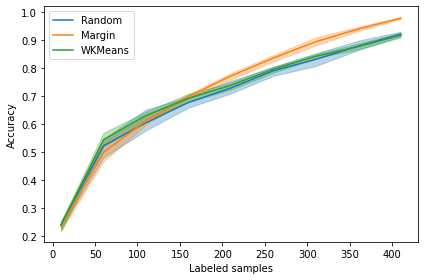

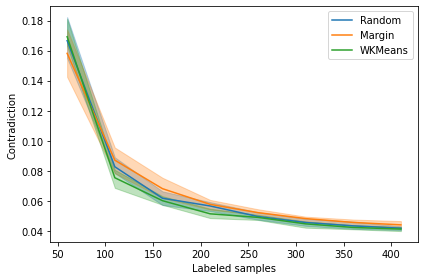

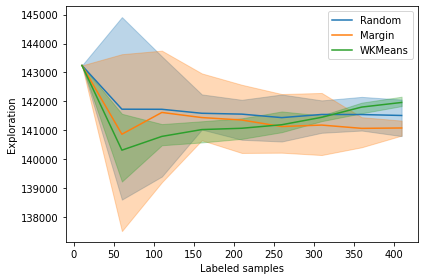

In [19]:
from cardinal.uncertainty import MarginSampler
from cardinal.random import RandomSampler
from cardinal.zhdanov2019 import TwoStepKMeansSampler
from cardinal.plotting import plot_confidence_interval
from matplotlib import pyplot as plt
from cardinal.utils import ActiveLearningSplitter


samplers = [
    ('Random', RandomSampler(batch_size)),
    ('Margin', MarginSampler(model, batch_size, assume_fitted=True)),
    ('WKMeans', TwoStepKMeansSampler(10, model, batch_size, assume_fitted=True))
]

figure_accuracies = plt.figure().number
figure_contradictions = plt.figure().number
figure_explorations = plt.figure().number
idxs = {}

for sampler_name, sampler in samplers:
    
    all_accuracies = []
    all_contradictions = []
    all_explorations = []

    for k in range(10):
        # We initialize the splitter with a train set only
        idx = ActiveLearningSplitter(X_train.shape[0])

        accuracies = []
        contradictions = []
        explorations = []

        # For simplicity, the first batch is simply one sample from each class
        one_per_class = np.unique(y_train[idx.non_selected], return_index=True)[1]
        idx.add_batch(one_per_class)

        # A classic active learning loop
        previous_pred_proba = None
        for j in range(n_iter):
            model.fit(X_train[idx.selected], y_train[idx.selected])
            accuracies.append(model.score(X_train, y_train))
            current_pred_proba = model.predict_proba(X_test)
            if previous_pred_proba is not None:
                contradictions.append(compute_contradiction(previous_pred_proba, current_pred_proba))
            previous_pred_proba = current_pred_proba
            explorations.append(compute_exploration(X_train[idx.selected], X_test))
            sampler.fit(X_train[idx.selected], y_train[idx.selected])
            idx.add_batch(sampler.select_samples(X_train[idx.non_selected]))

        all_accuracies.append(accuracies)
        all_contradictions.append(contradictions)
        all_explorations.append(explorations)
    
    # Keep the last splitter
    idxs[sampler_name] = idx
    
    x_data = np.arange(10, batch_size * (n_iter - 1) + 11, batch_size)

    plt.figure(figure_accuracies)
    plot_confidence_interval(x_data, all_accuracies, label=sampler_name)

    plt.figure(figure_contradictions)
    plot_confidence_interval(x_data[1:], all_contradictions, label=sampler_name)
    
    plt.figure(figure_explorations)
    plot_confidence_interval(x_data, all_explorations, label=sampler_name)
    
plt.figure(figure_accuracies)
plt.xlabel('Labeled samples')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.figure(figure_contradictions)
plt.xlabel('Labeled samples')
plt.ylabel('Contradiction')
plt.legend()
plt.tight_layout()

plt.figure(figure_explorations)
plt.xlabel('Labeled samples')
plt.ylabel('Exploration')
plt.legend()
plt.tight_layout()

plt.show()

# Evaluation

Once you have chosen your sampler, specify it below and get your score!

In [21]:
my_sampler = YOUR SAMPLER HERE

In [23]:
accuracies = []

y_test = np.loadtxt('admin/y_test.csv')
idx = ActiveLearningSplitter(X_test.shape[0])

for j in range(n_iter):
    Xj = np.vstack([X_train, X_test[idx.selected]])
    yj = np.hstack([y_train, y_test[idx.selected]])
    model.fit(Xj, yj)
    accuracies.append(model.score(X_test, y_test))
    my_sampler.fit(Xj, yj)
    idx.add_batch(my_sampler.select_samples(X_test[idx.non_selected]))

print(np.sum(accuracies))

6.281
